#  _dMasif for ADP binding site prediction_

This was my submission for the assessment of the 2023 [Geometric Deep Learning](https://www.cs.ox.ac.uk/teaching/courses/2022-2023/geodl/) course from University of Oxford.

This notebook contains a stand-alone reimplementation of the dMasif model for protein binding site prediction done in Julia.

The dMasif model was introduced in: 
>F. Sverrisson, J. Feydy, B. E. Correia and M. M. Bronstein, "Fast end-to-end learning on protein surfaces," 2021 IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR), https://doi.org/10.1109/CVPR46437.2021.01502.

It has seen further developments:
> Marchand, A., Buckley, S., Schneuing, A. et al. Targeting protein–ligand neosurfaces with a generalizable deep learning tool. Nature 639, 522–531 (2025). https://doi.org/10.1038/s41586-024-08435-4

## Setup
In Colab, click **Runtime → Change runtime type** and select **Julia**, ideally with GPU enabled.

In [1]:
# Instantiate all packages from the project manifest
import Pkg
Pkg.instantiate()

Check installation

In [2]:
versioninfo()
using CUDA
@info "CUDA functional: $(CUDA.functional())"

Julia Version 1.12.4
Commit 01a2eadb047 (2026-01-06 16:56 UTC)
Build Info:
  Official https://julialang.org release
Platform Info:
  OS: macOS (arm64-apple-darwin24.0.0)
  CPU: 12 × Apple M3 Pro
  WORD_SIZE: 64
  LLVM: libLLVM-18.1.7 (ORCJIT, apple-m3)
  GC: Built with stock GC
Threads: 1 default, 1 interactive, 1 GC (on 6 virtual cores)


┌ Info: CUDA functional: false
└ @ Main /Users/2648894/Code/dMaSIF-ligand/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X10sZmlsZQ==.jl:3


In [3]:
# @title Import the required packages

# Machine Learning
using CUDA
using Flux
using OneHotArrays

using BenchmarkTools
using Logging
using LinearAlgebra
using Statistics
using Distributions
using Distances
using LogExpFunctions: logsumexp as lsumexp

using Plots
using Random
Random.seed!(1234);

First, let us get some protein-ligand binding structure data. We will focus on ADP binding proteins. We will get the data from the [Protein Data Bank (PDB)](https://www.rcsb.org/)

In [5]:
using HTTP
using JSON

NUM_PROTEINS = 50

function fetch_adp_pdb_ids(n::Int)
    query = Dict(
        "query" => Dict(
            "type" => "group",
            "logical_operator" => "and",
            "nodes" => [
                Dict(
                    "type" => "terminal",
                    "service" => "text",
                    "parameters" => Dict(
                        "attribute" => "rcsb_nonpolymer_instance_annotation.comp_id",
                        "operator"  => "exact_match",
                        "value"     => "ADP"
                    )
                ),
                Dict(
                    "type" => "terminal",
                    "service" => "text",
                    "parameters" => Dict(
                        "attribute" => "rcsb_entry_info.resolution_combined",
                        "operator"  => "less_or_equal",
                        "value"     => 2.5
                    )
                ),
                Dict(
                    "type" => "terminal",
                    "service" => "text",
                    "parameters" => Dict(
                        "attribute" => "rcsb_entry_info.polymer_entity_count",
                        "operator" => "equals",
                        "value" => 1
                    )
                ),
                Dict(
                    "type" => "terminal",
                    "service" => "text",
                    "parameters" => Dict(
                        "attribute" => "rcsb_entry_info.molecular_weight",
                        "operator" => "less_or_equal",
                        "value" => 20000 # in daltons
                    )
                )
            ]
        ),
        "return_type" => "entry",
        "request_options" => Dict(
            "paginate" => Dict("start" => 0, "rows" => n)
        )
    )
    resp = HTTP.post(
        "https://search.rcsb.org/rcsbsearch/v2/query",
        ["Content-Type" => "application/json"],
        JSON.json(query)
    )
    result = JSON.parse(String(resp.body))
    return [r["identifier"] for r in result["result_set"]]
end

function download_pdb(id::String; outdir="data")
    path = joinpath(outdir, id * ".pdb")
    isfile(path) && return path   
    url  = "https://files.rcsb.org/download/$(id).pdb"
    write(path, HTTP.get(url).body)
    return path
end

mkpath("data")
pdb_ids = fetch_adp_pdb_ids(NUM_PROTEINS)
@info "Found $(length(pdb_ids)) PDB entries"

downloaded = String[]
for id in pdb_ids
    try
        download_pdb(id)
        push!(downloaded, id)
    catch e
        @warn "Failed to download $id" exception=e
    end
end
@info "Downloaded $(length(downloaded)) / $(length(pdb_ids)) PDB files"


┌ Info: Found 50 PDB entries
└ @ Main /Users/2648894/Code/dMaSIF-ligand/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W3sZmlsZQ==.jl:74
┌ Info: Downloaded 50 / 50 PDB files
└ @ Main /Users/2648894/Code/dMaSIF-ligand/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W3sZmlsZQ==.jl:85


## Part 1: Generate surface data from atom data

In [6]:
using BioStructures
using Bio3DView
import Flux: Chain  # resolve ambiguity: BioStructures also exports Chain

adpselector(res) = resnameselector(res, ["ADP"])
const ELEMENTS = ["C", "H", "N", "O", "S", "SE"]
const ELEMENT_IDS = Dict([(ELEMENTS[i], i) for i in eachindex(ELEMENTS)])
const RADII = [1.7, 1.1, 1.52, 1.55, 1.80, 1.90] # van der waals radii

function get_atom_data(struc::StructuralElement)
    aminoacids = collectresidues(struc, standardselector)
    coords = coordarray(aminoacids)

    types = get.(Ref(ELEMENT_IDS), element.(collectatoms(aminoacids); strip=true), 2)

    adps = collectresidues(struc, adpselector)
    adp_coords = coordarray(adps)

    # hack to be able to handle proteins which don't bind to ADP
    if isempty(adp_coords)
        adp_coords = reshape([1e6, 1e6, 1e6], 3, 1)
    end
    return coords, types, adp_coords
end

struc = read("data/1BUP.pdb", PDBFormat)
coords, types, adp_coords = get_atom_data(struc)
viewstruc(struc)


HTML{String}("<script type='text/javascript'>/*! jQuery v3.3.1 | (c) JS Foundation and other contributors | jquery.org/license */\n!function(e,t){\"use strict\";\"object\"==typeof module&&\"object\"==typeof module.exports?module.exports=e.document?t(e,!0):function(e){if(!e.document)throw new Error(\"jQuery requires a window with a document\");return t(e)}:t(e)}(\"undefined\"!=typeof window?window:this,function(e,t){\"use strict\";var n=[],r=e.document,i=Object.getPrototypeOf,o=n.slice,a=n.concat,s=n.push,u=n.indexOf,l={},c=l.toString,f=l.hasOwnProperty,p=f.toString,d=p.call(Object),h={},g=function e(t){return\"function\"==typeof t&&\"number\"!=typeof t.nodeType},y=function e(t){return null!=t&&t===t.window},v={type:!0,src:!0,noModule:!0};function m(e,t,n){var i,o=(t=t||r).createElement(\"script\");if(o.text=e,n)for(i in v)n[i]&&(o[i]=n[i]);t.head.appendChild(o).parentNode.removeChild(o)}function x(e){return null==e?e+\"\":\"object\"==typeof e||\"function\"==typeof e?l[c.call(e)]||\"object\":typeof e}var b=\"3.3.1\",w=function(e,t){return new w.fn.init(e,t)},T=/^[\\s\\uFEFF\\xA0]+|[\\s\\uFEFF\\xA0]+\$/g;w.fn=w.prototype={jquery:\"3.3.1\",constructor:w,length:0,toArray:function(){return o.call(this)},get:function(e){return null==e?o.call(this):e<0?this[e+this.length]:this[e]},pushStack:function(e){var t=w.merge(this.constructor(),e);return t.prevObject=this,t},each:function(e){return w.each(this,e)},map:function(e){return this.pushStack(w.map(this,function(t,n){return e.call(t,n,t)}))},slice:function(){return this.pushStack(o.apply(this,arguments))},first:function(){return this.eq(0)},last:function(){return this.eq(-1)},eq:function(e){var t=this.length,n=+e+(e<0?t:0);return this.pushStack(n>=0&&n<t?[this[n]]:[])},end:function(){return this.prevObject||this.constructor()},push:s,sort:n.sort,splice:n.splice},w.extend=w.fn.extend=function(){var e,t,n,r,i,o,a=arguments[0]||{},s=1,u=arguments.length,l=!1;for(\"boolean\"==typeof a&&(l=a,a=arguments[s]||{},s++),\"object\"==typeof a||g(a)||(a={}),s===u&&(a=this,s--);s<u;s++)if(null!=(e=arguments[s]))for(t in e)n=a[t],a!==(r=e[t])&&(l&&r&&(w.isPlainObject(r)||(i=Array.isArray(r)))?(i?(i=!1,o=n&&Array.isArray(n)?n:[]):o=n&&w.isPlainObject(n)?n:{},a[t]=w.extend(l,o,r)):void 0!==r&&(a[t]=r));return a},w.extend({expando:\"jQuery\"+(\"3.3.1\"+Math.random()).replace(/\\D/g,\"\"),isReady:!0,error:function(e){throw new Error(e)},noop:function(){},isPlainObject:function(e){var t,n;return!(!e||\"[object Object]\"!==c.call(e))&&(!(t=i(e))||\"function\"==typeof(n=f.call(t,\"constructor\")&&t.constructor)&&p.call(n)===d)},isEmptyObject:function(e){var t;for(t in e)return!1;return!0},globalEval:function(e){m(e)},each:function(e,t){var n,r=0;if(C(e)){for(n=e.length;r<n;r++)if(!1===t.call(e[r],r,e[r]))break}else for(r in e)if(!1===t.call(e[r],r,e[r]))break;return e},trim:function(e){return null==e?\"\":(e+\"\").replace(T,\"\")},makeArray:function(e,t){var n=t||[];return null!=e&&(C(Object(e))?w.merge(n,\"string\"==typeof e?[e]:e):s.call(n,e)),n},inArray:function(e,t,n){return null==t?-1:u.call(t,e,n)},merge:function(e,t){for(var n=+t.length,r=0,i=e.length;r<n;r++)e[i++]=t[r];return e.length=i,e},grep:function(e,t,n){for(var r,i=[],o=0,a=e.length,s=!n;o<a;o++)(r=!t(e[o],o))!==s&&i.push(e[o]);return i},map:function(e,t,n){var r,i,o=0,s=[];if(C(e))for(r=e.length;o<r;o++)null!=(i=t(e[o],o,n))&&s.push(i);else for(o in e)null!=(i=t(e[o],o,n))&&s.push(i);return a.apply([],s)},guid:1,support:h}),\"function\"==typeof Symbol&&(w.fn[Symbol.iterator]=n[Symbol.iterator]),w.each(\"Boolean Number String Function Array Date RegExp Object Error Symbol\".split(\" \"),function(e,t){l[\"[object \"+t+\"]\"]=t.toLowerCase()});function C(e){var t=!!e&&\"length\"in e&&e.length,n=x(e);return!g(e)&&!y(e)&&(\"array\"===n||0===t||\"number\"==typeof t&&t>0&&t-1 in e)}var E=function(e){var t,n,r,i,o,a,s,u,l,c,f,p,d,h,g,y,v,m,x,b=\"sizzle\"+1*new Date,w=e.document,T=0,C=0,E=ae(),k=ae(),S=ae(),D=function(e,t){return e===t&&(f=!0),0},N

Optimised sdf functions

In [7]:
# low memory implementation of SDF
# to make faster - batch it up to enable parallelism
function sdf(x, coords, radii; ideal_dist = 1.05)
    a = coords
    vecs = similar(a)
    d = similar(a, 1, size(a, 2))
    v = similar(d)
    res = []
    for x_i in eachcol(x)
        vecs .= (x_i .- a).^2
        sum!(d, vecs)                               # d = sqdists(x_i, a)
        d .= .-sqrt.(d)                             # d = -dists(x_i, a)
        v .= d ./ radii'
        L = lsumexp(v)                              # L = logsumexp(-dists(x_i, a) / radii)
        d .= exp.(d)                                # d = exp.(-dists(x_i, a))
        σ = dot(d, radii') / sum(d)                 # σ = smoothed mean atom radius weighted by exp(-dists)
        push!(res, -σ*L)
    end
    return res .- ideal_dist
end


# memory heavy but correct
function heavy_sdf(x, coords, radii; ideal_dist = 1.05)
    sqdists = sum((reshape(x, 3, :, 1) .- reshape(coords, 3, 1, :)).^2; dims=1)
    dists = sqrt.(dropdims(sqdists; dims=1))
    expneg_dists= exp.(-dists)
    softavg_nbhrad = sum(expneg_dists .* radii'; dims=2) ./ sum(expneg_dists; dims=2)

    return vec(-softavg_nbhrad .* lsumexp(-dists ./ radii'; dims=2) .- ideal_dist)
end

#∇ₓSDF - low memory - to make faster should operate in bigger batches of columns over x
function grad_sdf(x, coords, radii)
    a = coords
    vecs = similar(a)
    d = similar(a, 1, size(a, 2)) # -dists
    ed = similar(d) # exp(-dists)
    nd = similar(d) # -dists(x_i, a) / radii (normalized dists by radius)
    grads = similar(x)

    for (i, x_i) in enumerate(eachcol(x))
        vecs .= (x_i .- a).^2
        sum!(d, vecs)                               # d = sqdists(x_i, a)
        d .= .-sqrt.(d)                             # d = -dists(x_i, a)
        nd .= d ./ radii'                           # nd = -dists(x_i, a) / radii
        ed .= exp.(d)                               # ed = exp(-dists)

        L = lsumexp(nd)                             # L = logsumexp(-dists(x_i, a)/radii)
        ϕ = sum(ed)
        ψ = dot(ed, radii')
        σ = ψ / ϕ

        # add σ*∇L
        vecs .= exp.(nd)  ./ (d .* radii') .* (x_i .- a)
        @views grads[:, i] .= -σ * sum(vecs;dims=2) / exp(L)

        # add ∇ϕ component
        vecs .= (ed ./ d) .* (x_i .- a) # ∇ϕ component
        @views grads[:, i] .-= -ψ * L * sum(vecs;dims=2) / ϕ^2

        # add ∇ψ component
        vecs .*= radii' # ∇ψ component
        @views grads[:, i] .-= ϕ * L * sum(vecs;dims=2) / ϕ^2
    end

    return grads
end

# Profiling and correctness checks 
function check_sdf()
    xx = rand(3, 4000)
    c = rand(3, 2000)
    r = rand(2000)

    println("My sdf")
    @time sdf(xx, c, r)
    println("Heavy sdf")
    @time heavy_sdf(xx, c, r)

    @assert isapprox(sdf(xx, c, r), heavy_sdf(xx, c, r))

    msd(x) = sum(heavy_sdf(x, c, r))
    println("My grad")
    @time grad_sdf(xx, c, r)
    println("Heavy grad")
    @time gradient(msd, xx)[1]

    @assert isapprox(grad_sdf(xx, c, r), gradient(msd, xx)[1])
end
check_sdf()

My sdf
  0.109728 seconds (29.80 k allocations: 1.263 MiB, 11.86% compilation time)
Heavy sdf
  0.398611 seconds (49 allocations: 610.689 MiB, 68.93% gc time)
My grad
  0.303563 seconds (72.02 k allocations: 3.484 MiB)
Heavy grad
  1.739275 seconds (1.48 M allocations: 2.213 GiB, 25.48% gc time, 53.73% compilation time)


In [9]:
function sample_surface(coords, radii; 
                        samples_per_atom=1, num_iters=10, step_size=2.0, error_margin=0.3,
                        batch_size=2000)
    A = size(coords, 2)
    B = samples_per_atom

    mysdf(p) = sdf(p, coords, radii)
    mygrad_sdf(p) = grad_sdf(p, coords, radii)

    # Step 1 - Sample point cloud around atoms
    @info "initial #samples " * string(A*B)
    x = rand(Normal(0.0, 1.0), 3, A, B) 
    x .= x .* reshape(radii, 1, :, 1) .+ reshape(coords, 3, :, 1)
    x = reshape(x, 3, :) # size(x) = (3, A*B)

    # Step 2 - Bring points closer to surface by minimizing the squared sdf
    #          via gradient descent
    @info "Attracting samples to surface via gradient descent"
    batches = collect(Iterators.partition(axes(x, 2), batch_size))
    for i in 1:num_iters
        #n.b. this could be done on the gpu and would be much faster
        Threads.@threads for cols in batches
            @views x_batch = x[:, cols]
            x_batch .-= step_size .* mysdf(x_batch)' .* mygrad_sdf(x_batch) # grad(mse(sdf))
        end
        @info "Loss at iter $i: " * string(mean(mysdf(x).^2) / 2)
    end

    # Step 3 - Clean the samples

    # Discard samples far away from the surface
    mask = abs.(mysdf(x)) .< error_margin
    x = x[:, mask]
    @info "#samples left after distance cull: " * string(count(mask))

    # Compute normals as gradient of surface implicit function (aka sdf)
    normals = mygrad_sdf(x)
    foreach(normalize!, eachcol(normals))

    # Discard samples nested inside the protein 
    # i.e. if moving "upwards" by 4Å actually reduces the distance to the surface
    mask = (mysdf(x .+ 4 .* normals) .- mysdf(x)) .> 0.5
    x = x[:, mask]
    normals = normals[:, mask]
    @info "#samples left after trapped cull: " * string(count(mask))

    # Step 4 - subsampling - make sure sampling was uniform in space
    # For each cubic bin of size 0.5Å we keep one sample per cell

    # technically this is not subsampling because it is deterministic and always chooses 
    # one point per grid; might give slightly biased results
    grid_loc = floor.(Int, x)
    unique_idx = unique(i -> grid_loc[:, i], 1:size(x, 2))
    x = x[:, unique_idx]
    normals = normals[:, unique_idx]
    @info "#samples left after subsampling: " * string(length(unique_idx))

    return x, normals
end

radii = RADII[types]
x, normals = sample_surface(coords, radii);

┌ Info: initial #samples 2902
└ @ Main /Users/2648894/Code/dMaSIF-ligand/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X16sZmlsZQ==.jl:11
┌ Info: Attracting samples to surface via gradient descent
└ @ Main /Users/2648894/Code/dMaSIF-ligand/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X16sZmlsZQ==.jl:18
┌ Info: Loss at iter 1: 4.61019607500975
└ @ Main /Users/2648894/Code/dMaSIF-ligand/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X16sZmlsZQ==.jl:26
┌ Info: Loss at iter 2: 3.545039493024641
└ @ Main /Users/2648894/Code/dMaSIF-ligand/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X16sZmlsZQ==.jl:26
┌ Info: Loss at iter 3: 2.8927971538965593
└ @ Main /Users/2648894/Code/dMaSIF-ligand/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X16sZmlsZQ==.jl:26
┌ Info: Loss at iter 4: 2.458221086222629
└ @ Main /Users/2648894/Code/dMaSIF-ligand/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X16sZmlsZQ==.jl:26
┌ Info: Loss at iter 5: 2.1642232581888834
└ @ Main /Users/2648894/Code

In [10]:
# Returns for each x_i in x the indices of the kth nearest points in coords and the 
# distances to them
function knearest(x, coords; k=16)
    vecs = similar(coords)
    sqdists = similar(coords, size(coords, 2))
    ids = Array{Integer}(undef, k, size(x, 2))
    dists = similar(x, k, size(x, 2))
    # hot loop
    for (i, x_i) in enumerate(eachcol(x))
        vecs .= (x_i .- coords).^2
        sqdists .= dropdims(sum(vecs; dims=1);dims=1)                             
        @views ids[:, i] .= sortperm(sqdists; alg=PartialQuickSort(k))[1:k]
        @views dists[:, i] .= sqrt.(sqdists[ids[:, i]])
    end
    return ids, dists
end

nbh_atom_ids, dists = knearest(x, coords; k=8)

t = reshape(types[vec(nbh_atom_ids)], size(nbh_atom_ids))
t_onehot = onehotbatch(t, 1:6, 2)
inv_dists = 1 ./ dists # size = 16 x num_samples

labels = knearest(x, adp_coords; k=1)[2] .< 10.0

count(labels)

34

Plot the resulting surface

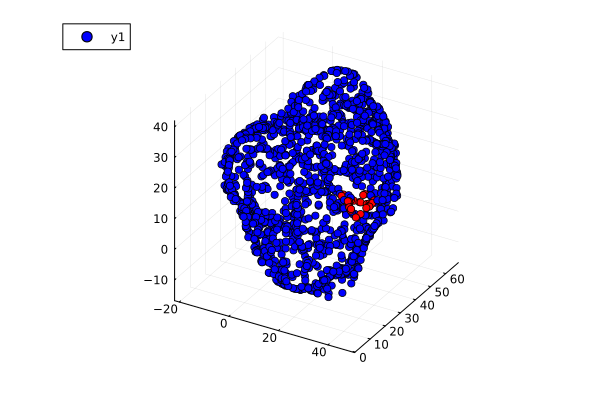

In [11]:
function plot_surface(pos, labels)
    colours = fill("blue", size(labels))
    colours[labels] .= "red"
    scatter(pos[1,:], pos[2,:], pos[3,:], color=vec(colours))
end

plot_surface(x, labels)

┌ Info: initial #samples 1267
└ @ Main /Users/2648894/Code/dMaSIF-ligand/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X16sZmlsZQ==.jl:11
┌ Info: Attracting samples to surface via gradient descent
└ @ Main /Users/2648894/Code/dMaSIF-ligand/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X16sZmlsZQ==.jl:18
┌ Info: Loss at iter 1: 4.056099128363857
└ @ Main /Users/2648894/Code/dMaSIF-ligand/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X16sZmlsZQ==.jl:26
┌ Info: Loss at iter 2: 2.949937101317081
└ @ Main /Users/2648894/Code/dMaSIF-ligand/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X16sZmlsZQ==.jl:26
┌ Info: Loss at iter 3: 2.329651421596085
└ @ Main /Users/2648894/Code/dMaSIF-ligand/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X16sZmlsZQ==.jl:26
┌ Info: Loss at iter 4: 1.9238581654342093
└ @ Main /Users/2648894/Code/dMaSIF-ligand/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X16sZmlsZQ==.jl:26
┌ Info: Loss at iter 5: 1.651444089933377
└ @ Main /Users/2648894/Code

  1.434948 seconds (2.93 M allocations: 161.145 MiB, 1.05% gc time, 22.46% compilation time)


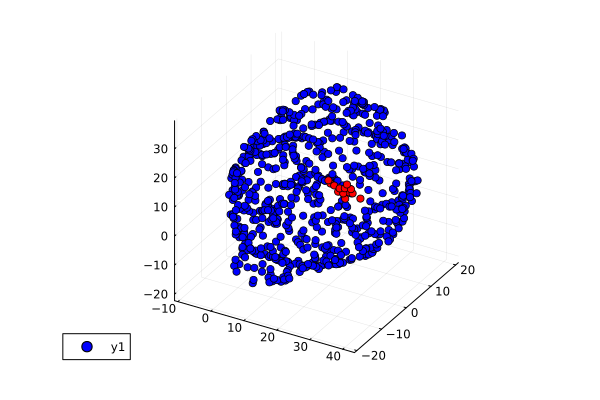

In [13]:
#@title Putting it all together
function process_data_from_pdb(id::String; 
                               atom_nbh_size=8, ligand_bind_range=3.0)
    struc = read("data/" * id * ".pdb", PDBFormat)
    viewstruc(struc)
    atom_coords, atom_types, adp_coords = get_atom_data(struc)
    atom_radii = RADII[atom_types]

    # Sample oriented point cloud surface from atom metaball 
    pos, normals = sample_surface(atom_coords, atom_radii; num_iters=10)
    nbh_atom_ids, atom_dists = knearest(pos, atom_coords; k=atom_nbh_size)

    sample_types = reshape(atom_types[vec(nbh_atom_ids)], size(nbh_atom_ids))
    types_onehot = onehotbatch(sample_types, 1:6, 2) 
    inv_dists = 1 ./ atom_dists # atom_nbh_size x num_samples

    # 7 x atom_nbh_size x num_samples
    feats = cat(types_onehot, reshape(inv_dists, 1, atom_nbh_size, :) ;dims=1)

    labels = knearest(pos, adp_coords; k=1)[2] .< ligand_bind_range

    return (pos=pos, normals=normals, feats=feats, labels=labels)
end

@time data = process_data_from_pdb("1EQM");
plot_surface(data[:pos], vec(data[:labels]))

In [14]:
viewstruc(read("data/1EQM.pdb", PDBFormat))

HTML{String}("<script type='text/javascript'>/*! jQuery v3.3.1 | (c) JS Foundation and other contributors | jquery.org/license */\n!function(e,t){\"use strict\";\"object\"==typeof module&&\"object\"==typeof module.exports?module.exports=e.document?t(e,!0):function(e){if(!e.document)throw new Error(\"jQuery requires a window with a document\");return t(e)}:t(e)}(\"undefined\"!=typeof window?window:this,function(e,t){\"use strict\";var n=[],r=e.document,i=Object.getPrototypeOf,o=n.slice,a=n.concat,s=n.push,u=n.indexOf,l={},c=l.toString,f=l.hasOwnProperty,p=f.toString,d=p.call(Object),h={},g=function e(t){return\"function\"==typeof t&&\"number\"!=typeof t.nodeType},y=function e(t){return null!=t&&t===t.window},v={type:!0,src:!0,noModule:!0};function m(e,t,n){var i,o=(t=t||r).createElement(\"script\");if(o.text=e,n)for(i in v)n[i]&&(o[i]=n[i]);t.head.appendChild(o).parentNode.removeChild(o)}function x(e){return null==e?e+\"\":\"object\"==typeof e||\"function\"==typeof e?l[c.call(e)]||\"object\":typeof e}var b=\"3.3.1\",w=function(e,t){return new w.fn.init(e,t)},T=/^[\\s\\uFEFF\\xA0]+|[\\s\\uFEFF\\xA0]+\$/g;w.fn=w.prototype={jquery:\"3.3.1\",constructor:w,length:0,toArray:function(){return o.call(this)},get:function(e){return null==e?o.call(this):e<0?this[e+this.length]:this[e]},pushStack:function(e){var t=w.merge(this.constructor(),e);return t.prevObject=this,t},each:function(e){return w.each(this,e)},map:function(e){return this.pushStack(w.map(this,function(t,n){return e.call(t,n,t)}))},slice:function(){return this.pushStack(o.apply(this,arguments))},first:function(){return this.eq(0)},last:function(){return this.eq(-1)},eq:function(e){var t=this.length,n=+e+(e<0?t:0);return this.pushStack(n>=0&&n<t?[this[n]]:[])},end:function(){return this.prevObject||this.constructor()},push:s,sort:n.sort,splice:n.splice},w.extend=w.fn.extend=function(){var e,t,n,r,i,o,a=arguments[0]||{},s=1,u=arguments.length,l=!1;for(\"boolean\"==typeof a&&(l=a,a=arguments[s]||{},s++),\"object\"==typeof a||g(a)||(a={}),s===u&&(a=this,s--);s<u;s++)if(null!=(e=arguments[s]))for(t in e)n=a[t],a!==(r=e[t])&&(l&&r&&(w.isPlainObject(r)||(i=Array.isArray(r)))?(i?(i=!1,o=n&&Array.isArray(n)?n:[]):o=n&&w.isPlainObject(n)?n:{},a[t]=w.extend(l,o,r)):void 0!==r&&(a[t]=r));return a},w.extend({expando:\"jQuery\"+(\"3.3.1\"+Math.random()).replace(/\\D/g,\"\"),isReady:!0,error:function(e){throw new Error(e)},noop:function(){},isPlainObject:function(e){var t,n;return!(!e||\"[object Object]\"!==c.call(e))&&(!(t=i(e))||\"function\"==typeof(n=f.call(t,\"constructor\")&&t.constructor)&&p.call(n)===d)},isEmptyObject:function(e){var t;for(t in e)return!1;return!0},globalEval:function(e){m(e)},each:function(e,t){var n,r=0;if(C(e)){for(n=e.length;r<n;r++)if(!1===t.call(e[r],r,e[r]))break}else for(r in e)if(!1===t.call(e[r],r,e[r]))break;return e},trim:function(e){return null==e?\"\":(e+\"\").replace(T,\"\")},makeArray:function(e,t){var n=t||[];return null!=e&&(C(Object(e))?w.merge(n,\"string\"==typeof e?[e]:e):s.call(n,e)),n},inArray:function(e,t,n){return null==t?-1:u.call(t,e,n)},merge:function(e,t){for(var n=+t.length,r=0,i=e.length;r<n;r++)e[i++]=t[r];return e.length=i,e},grep:function(e,t,n){for(var r,i=[],o=0,a=e.length,s=!n;o<a;o++)(r=!t(e[o],o))!==s&&i.push(e[o]);return i},map:function(e,t,n){var r,i,o=0,s=[];if(C(e))for(r=e.length;o<r;o++)null!=(i=t(e[o],o,n))&&s.push(i);else for(o in e)null!=(i=t(e[o],o,n))&&s.push(i);return a.apply([],s)},guid:1,support:h}),\"function\"==typeof Symbol&&(w.fn[Symbol.iterator]=n[Symbol.iterator]),w.each(\"Boolean Number String Function Array Date RegExp Object Error Symbol\".split(\" \"),function(e,t){l[\"[object \"+t+\"]\"]=t.toLowerCase()});function C(e){var t=!!e&&\"length\"in e&&e.length,n=x(e);return!g(e)&&!y(e)&&(\"array\"===n||0===t||\"number\"==typeof t&&t>0&&t-1 in e)}var E=function(e){var t,n,r,i,o,a,s,u,l,c,f,p,d,h,g,y,v,m,x,b=\"sizzle\"+1*new Date,w=e.document,T=0,C=0,E=ae(),k=ae(),S=ae(),D=function(e,t){return e===t&&(f=!0),0},N

## Part 2: Learning over the protein surface data

Geodesic distance utils

In [15]:
function dists_dots(x, n, nbh_ids)
    k = size(nbh_ids, 1)
    vecs = similar(x, 3, k)
    v = similar(x, k)
    dists = similar(x, k, size(x, 2))
    dots = similar(dists)
    # hot loop
    for i in axes(x, 2)
        @views x_i = x[:, i]; n_i = n[:, i]
        vecs .= (x_i .- x[:, nbh_ids[:, i]]).^2
        v .= dropdims(sum(vecs; dims=1);dims=1)                             
        @views dists[:, i] .= sqrt.(v)

        vecs .= (n_i .* n[:, nbh_ids[:, i]])
        v .= dropdims(sum(vecs; dims=1);dims=1)  
        @views dots[:, i] .= v
    end
    return dists, dots
end

function quasi_geodesic_dist(x, n, nbh_ids; λ=1)
    dists, dots = dists_dots(x, n, nbh_ids)

    return dists .* (1 .+ λ .* (1 .- dots))
end

function my_geodesic_dist(x, n, nbh_ids)
    dists, dots = dists_dots(x, n, nbh_ids)
    clamp!(dots, -1.0+1e-14, 1.0-1e-14)
    return dists .* acos.(dots) ./ sqrt.(2 .- 2 .* dots)
end

# Process dists so that they can be used inside the gaussian filter
function gaussian_filter!(dists; σ=9)
    dists .= exp.(.-dists.^2 ./ (2 .* σ^2))
    return dists
end

nbh_ids, dists = knearest(x, x; k=100);

3D Geometry methods

In [16]:
# Generate arbitrary local reference frames for each normal
function nuv_from_n(n)
    @views x = n[1, :]; y = n[2, :]; z = n[3, :]
    s = sign.(z)
    a = -1.0 ./ (s .+ z)
    b = a .* x .* y

    u = similar(n)
    u[1, :] .= 1 .+ s .* a .* x .* x 
    u[2, :] .= s .* b 
    u[3, :] .= .- s .* x 

    v = similar(n)
    v[1, :] .= b 
    v[2, :] .= s .+ a .* y .* y 
    v[3, :] .= .-y

    nuv = cat(reshape(n, 3, 1, :) , reshape(u, 3, 1, :), reshape(v,3, 1,:); dims=2)
    # size nuv = (3, 3, num_samples)
    return nuv
end

# Compute positions of neighbours w.r.t local reference frames
function local_pos(pos, frame, nbh_ids)
    # size(frame, 1) = 3
    k = size(frame, 2) # ∈ [1, 2, 3]
    @views res = map(i -> frame[:, :, i]' * (pos[:, nbh_ids[:, i]] .- pos[:, i]),axes(pos, 2))
    # size res[i] = (k, 3) * (3, nbh_size) = (k, nbh_size)

    # final size: (k, nbh_size, num_samples)
    return reshape(reduce(hcat, res), k, size(nbh_ids, 1), size(pos, 2))
end

nuv = nuv_from_n(normals)
local_pos(x, nuv, nbh_ids);

### Set up model

Chemical Layer - compute chemical embedding of points based on surrounding atoms 

In [17]:
struct ChemicalLayer
    atomMLP::Chain
    sampleMLP::Chain
end 
function ChemicalLayer(;input_dim=7, num_atoms=8, hidden_dim=12, emb_dim=6)
    atomMLP = Chain(Dense(input_dim => hidden_dim),
                    BatchNorm(hidden_dim, leakyrelu),
                    Dense(hidden_dim => emb_dim))
    sampleMLP = Chain(Dense(emb_dim => hidden_dim),
                      BatchNorm(hidden_dim, leakyrelu),
                      Dense(hidden_dim => emb_dim))
    return ChemicalLayer(atomMLP, sampleMLP)
end
function(m::ChemicalLayer)(x)
    # x: (input_dim, num_atoms, num_samples)
    input_dim, num_atoms, num_samples = size(x)
    # flatten atoms and samples so BatchNorm sees a 2D input
    x = reshape(x, input_dim, num_atoms * num_samples)
    x = m.atomMLP(x)                                    # (emb_dim, num_atoms*num_samples)
    x = reshape(x, :, num_atoms, num_samples)           # (emb_dim, num_atoms, num_samples)
    x = dropdims(sum(x; dims=2); dims=2)                # (emb_dim, num_samples)
    return m.sampleMLP(x)
end

Flux.@layer ChemicalLayer
model = ChemicalLayer() |> gpu
chem_emb = model(Float32.(data[:feats]) |> gpu) |> cpu

┌ Warning: No functional GPU backend found! Defaulting to CPU.
│ 
│ 1. If no GPU is available, nothing needs to be done. Set `MLDATADEVICES_SILENCE_WARN_NO_GPU=1` to silence this warning.
│ 2. If GPU is available, load the corresponding trigger package.
│     a. `CUDA.jl` and `cuDNN.jl` (or just `LuxCUDA.jl`) for  NVIDIA CUDA Support.
│     b. `AMDGPU.jl` for AMD GPU ROCM Support.
│     c. `Metal.jl` for Apple Metal GPU Support. (Experimental)
│     d. `oneAPI.jl` for Intel oneAPI GPU Support. (Experimental)
│     e. `OpenCL.jl` for OpenCL support. (Experimental)
└ @ MLDataDevices.Internal /Users/2648894/.julia/packages/MLDataDevices/4qHOT/src/internal.jl:114


6×754 Matrix{Float32}:
  0.994909   0.995885   1.1574    …   1.1507     1.15834    1.35734
  0.978614   0.979697   1.18705       1.18037    1.18799    1.09273
  0.430991   0.43155    0.55562       0.552528   0.556061   0.612619
  0.358316   0.358696   0.430707      0.428345   0.431041   0.41733
  0.219816   0.220122   0.286691      0.284961   0.286935   0.141267
 -1.03758   -1.03855   -1.1891    …  -1.18238   -1.19006   -1.24839

In [18]:
# Scalar field over protein surface
# Projecting its gradient onto the tangent plane yields a smooth vector field 
# This ensures that the gauge of the manifold is smooth and consistent which is important,
# because the convolution of the signal depends on the specific coordinate choice
struct PotentialLayer
    chain::Chain
end 
function PotentialLayer(;input_dim=6, hidden_dim=16)
    chain = Chain(Dense(input_dim => hidden_dim),
                  BatchNorm(hidden_dim, leakyrelu),
                  Dense(hidden_dim => hidden_dim),
                  BatchNorm(hidden_dim, leakyrelu),
                  Dense(hidden_dim => 1))
    return PotentialLayer(chain)
end
function(m::PotentialLayer)(x)
    return m.chain(x)
end
Flux.@layer PotentialLayer

potmodel = PotentialLayer() |> gpu 
pot = potmodel(chem_emb |> gpu) |> cpu

1×754 Matrix{Float32}:
 -0.106463  -0.106582  -0.12951  …  -0.128788  -0.129612  -0.0545126

In [19]:
struct ConvLayer
    local_mlp::Chain
end

function ConvLayer()
    local_mlp = Chain(Dense(3 => 16),
                      BatchNorm(16, leakyrelu),
                      Dense(16 => 1))
    return ConvLayer(local_mlp)
end

function (m::ConvLayer)(emb, window, p_ij, nbh_ids)
    # p_ij: (3, nbh_size, num_samples) → flatten for MLP → reshape back
    feat_dim, nbh_size, num_samples = size(p_ij)
    emb_dim = size(emb, 1)

    p_flat = reshape(p_ij, feat_dim, nbh_size * num_samples)
    w_ij = reshape(m.local_mlp(p_flat), 1, nbh_size, num_samples)   # (1, nbh_size, num_samples)

    emb_ij = reduce(hcat, map(i -> emb[:, nbh_ids[:, i]], axes(emb, 2)))
    emb_ij = reshape(emb_ij, emb_dim, nbh_size, num_samples)         # (emb_dim, nbh_size, num_samples)

    win = reshape(window, 1, nbh_size, num_samples)                   # (1, nbh_size, num_samples)

    out = dropdims(sum(win .* w_ij .* emb_ij; dims=2); dims=2)       # (emb_dim, num_samples)
    return out
end
Flux.@layer ConvLayer


In [20]:
function update_nuv(potentials, pos, nuv, nbh_ids, window)
    num_samples = size(pos, 2)

    window = reshape(window, 1, size(window)...)
    # size window = (1, nbh_size, num_samples)

    #pots_ij = p_j - p_i 
    # i.e. change of potential when going from i to j 
    ps = potentials
    @views pots_ij = reduce(hcat, map(i -> ps[:, nbh_ids[:, i]] .- ps[:, i], axes(pos, 2)))
    pots_ij = reshape(pots_ij, 1, :, num_samples)
    # size pots_ij = (1, nbh_size, num_samples)

    #p_ij_uv gives location of pos_j w.r.t. the tangent plane of point i 
    @views p_ij_uv = local_pos(pos, nuv[:, 2:3, :], nbh_ids)
    # size p_ij_uv = (2, nbh_size, num_samples)

    # new_u sits in the (u,v) plane
    new_u = dropdims(mean(window .* pots_ij .* p_ij_uv; dims=2);dims=2)
    # size new_u = (2, num_samples)
    # bring new_u to 3D => size = (3, num_samples)
    new_u = vcat(zeros(Float32, 1, num_samples), new_u)

    # rotate u counter clockwise by 90 degrees to get v
    # rot by 90deg: (x, y) -> (-y, x)
    @views new_v = vcat(zeros(Float32, 1, num_samples), -new_u[2, :]', new_u[1, :]')

    new_uv = cat(reshape(new_u, 3, 1, :), reshape(new_v, 3, 1, :); dims=2)
    # Finally, rotate new_u, new_v so that their normals match 
    # This amounts to reversing the local frame transformation
    @views new_uv = map(i -> inv(nuv[:, :, i])' * new_uv[:, :, i],axes(pos, 2))
    new_uv = reshape(reduce(hcat, new_uv), 3, 2, num_samples)

    @views n = reshape(nuv[:, 1, :], 3, 1, :)
    new_nuv = cat(n, new_uv; dims=2)

    return new_nuv
end

update_nuv (generic function with 1 method)

In [ ]:
struct DMasif
    chem_layer::ChemicalLayer
    potential_layer::PotentialLayer
    classifier_layer::Chain
    conv_layers::Vector{ConvLayer}
end

function DMasif(; n_conv=3)
    chem_layer = ChemicalLayer()
    potential_layer = PotentialLayer()
    classifier_layer = Chain(Dense(6 => 16),
                             BatchNorm(16, leakyrelu),
                             Dense(16 => 1))
    conv_layers = [ConvLayer() for _ in 1:n_conv]
    return DMasif(chem_layer, potential_layer, classifier_layer, conv_layers)
end


function (m::DMasif)(pos, nuv, feats, nbh_ids, window)
    # Compute embedding based on chemical properties
    emb = m.chem_layer(feats)

    # Update gauge based on gradient of potential
    potentials = m.potential_layer(emb)
    nuv = update_nuv(potentials, pos, nuv, nbh_ids, window)
    
    # Apply several quasi-geodesic convolutions to update embedding
    p_ij = local_pos(pos, nuv, nbh_ids)

    for layer in m.conv_layers
        emb = m.conv_layer(emb, window, p_ij, nbh_ids)
    end

    # Finally, classify point based on its embedding
    out = m.classifier_layer(emb)
    return out 
end
Flux.@layer DMasif

pos = data[:pos] 
nuv = nuv_from_n(data[:normals])
feats = data[:feats]
nbh_ids = copy(knearest(pos, pos; k=100)[1])
window = quasi_geodesic_dist(pos, data[:normals], nbh_ids)
gaussian_filter!(window)

model = DMasif()
affinity = model(pos, nuv, feats, nbh_ids, window) 


┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(7 => 12)
│   summary(x) = 7×6032 Matrix{Float64}
└ @ Flux /Users/2648894/.julia/packages/Flux/DZYiO/src/layers/stateless.jl:60


1×754 Matrix{Float32}:
 -0.956371  -0.860837  -2.46711  -0.956239  …  -1.23686  -1.28573  -0.763083

### Training

Prepare data

In [24]:
using JLD2

const PROCESSED_DIR = "processed"
mkpath(PROCESSED_DIR)

function preprocess_and_save(id::String; kwargs...)
    outpath = joinpath(PROCESSED_DIR, id * ".jld2")
    isfile(outpath) && (@debug "Skipping $id (cached)"; return outpath)

    data = process_data_from_pdb(id; kwargs...)
    n_pos = count(vec(data[:labels]))
    n_pts = size(data[:pos], 2)
    @debug "  $id: $n_pts surface points, $n_pos positive"


    frac = n_pos / n_pts
    if n_pos < 10 || frac > 0.75
        @warn "Skipping $id: degenerate labels (n_pos=$n_pos, frac=$(round(frac; digits=2)))"
        return nothing
    end

    jldsave(outpath;
        pos     = Float32.(data[:pos]),
        normals = Float32.(data[:normals]),
        feats   = Float32.(data[:feats]),
        labels  = vec(data[:labels]))
    return outpath
end

preprocess_and_save (generic function with 1 method)

In [ ]:
processed_ids = String[]
for id in downloaded
    @info "Processing $id..."
    result = preprocess_and_save(id)
    result !== nothing && push!(processed_ids, id)
end
@info "Successfully preprocessed $(length(processed_ids)) / $(length(downloaded)) proteins"

┌ Info: Processing 10BM...
└ @ Main /Users/2648894/Code/dMaSIF-ligand/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X55sZmlsZQ==.jl:3
┌ Info: initial #samples 11387
└ @ Main /Users/2648894/Code/dMaSIF-ligand/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X16sZmlsZQ==.jl:11
┌ Info: Attracting samples to surface via gradient descent
└ @ Main /Users/2648894/Code/dMaSIF-ligand/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X16sZmlsZQ==.jl:18
┌ Info: Loss at iter 1: 4.906913104772568
└ @ Main /Users/2648894/Code/dMaSIF-ligand/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X16sZmlsZQ==.jl:26
┌ Info: Loss at iter 2: 3.9765905422611234
└ @ Main /Users/2648894/Code/dMaSIF-ligand/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X16sZmlsZQ==.jl:26
┌ Info: Loss at iter 3: 3.3954579348949405
└ @ Main /Users/2648894/Code/dMaSIF-ligand/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X16sZmlsZQ==.jl:26
┌ Info: Loss at iter 4: 2.9915743082589272
└ @ Main /Users/2648894/Code/dMaSIF-ligan

In [ ]:
struct ProteinData
    pos::Matrix{Float32}
    normals::Matrix{Float32}
    feats::Array{Float32, 3}
    labels::BitVector
    nbh_ids::Matrix
    window::Matrix{Float32}
end

function load_protein(id)
    d = JLD2.load("data/processed/$id.jld2")
    pos = d["pos"]; normals = d["normals"]
    nbh_ids = knearest(pos, pos; k=100)[1]
    window  = quasi_geodesic_dist(pos, normals, nbh_ids)
    gaussian_filter!(window)
    return ProteinData(pos, normals, d["feats"], d["labels"], nbh_ids, Float32.(window))
end

Loss function

In [23]:
function balanced_bce(affinity, labels)
    pos_idx = findall(vec(labels))
    neg_idx = findall(.!vec(labels))
    n = min(length(pos_idx), length(neg_idx))
    neg_idx = neg_idx[randperm(length(neg_idx))[1:n]]
    idx = vcat(pos_idx, neg_idx)
    preds = vec(affinity)[idx]
    lbls = Float32.(vec(labels)[idx])
    return Flux.logitbinarycrossentropy(preds, lbls)
end

balanced_bce (generic function with 1 method)

Training loop

In [ ]:
# data augmentation
function random_rotation()
    Q = Matrix(qr(randn(3, 3)).Q)
    return Float32.(Q * sign(det(Q)))
end

function train_step!(model, opt_state, p::ProteinData)
    R = random_rotation()
    pos_r = R * p.pos
    nuv = nuv_from_n(R * p.normals)
    loss, grads = Flux.withgradient(model) do m
        balanced_bce(m(pos_r, nuv, p.feats, p.nbh_ids, p.window), p.labels)
    end

    Flux.update!(opt_state, model, grads[1])
    return loss    
end

In [ ]:
function train!(model, proteins; epochs=50, val_frac=0.1, lr=3f-4)
    n_val = max(1, round(Int, val_frac * length(proteins)))
    val_ids = proteins[1:n_val]
    trn_ids = proteins[n_val+1:end]

    trn_data = load_protein.(trn_ids)
    val_data = load_protein.(val_ids)

    opt_state = Flux.setup(Adam(lr), model)
    best_val = Inf

    for epoch in 1:epochs
        trn_loss = 0f0
        for p in trn_data[randperm(length(trn_data))]
            trn_loss += tran_step!(model, opt_state, p)
        end
        val_loss = mean(val_data) do p
            R = random_rotation()
            balanced_bce(model(R*p.pos, nuv_from_n(R*p.normals), p.feats, p.nbh_ids, p.window), p.labels)
        end
        @info "Epoch $epoch | trn=$(round(trn_loss/length(trn_data); digits=4)) | val=$(round(val_loss; digits=4))"
        if val_loss < best_val
            best_val = val_loss
            JLD2.jldsave("data/best_model.jld2"; model=Flux.state(model))
            @info " -> saved checpoint (val=$best_val)"
        end
    end
end